# Project Capstone:  NBA PLAYERS SCORING PREDICTION
## Nicolas Monvert, EPFL Extension School 2020
## Part 3 : Machine Learning 1

In this last section, I will be doing some trials to make the best prediction on my __regression problem__.

I test 4 different models on the single player I worked on during the EDA part.

In addition to this chosen player, I duplicated the current notebook for another player on the notebook ML_2. This might lead to some different conclusion, that some player may be more sensitive to certain features and therefore easier (or tougher) to predict.

In this notebook, I also worked on a model with all the features (x), and a slightly "lighter" version (x0).

### Import main librairies

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold

### Load CSV Files

In [2]:
lbj = pd.read_csv('lbj.csv')
print(lbj.shape)
lbj.head(3)

(1563, 104)


,GAME_ID,TEAM_ID,TEAM_CITY,PLAYER_NAME,FG_PCT,FGA,FGM,REB,MIN,PTS,...,Opponent_City_Oklahoma City,Opponent_City_Orlando,Opponent_City_Philadelphia,Opponent_City_Phoenix,Opponent_City_Portland,Opponent_City_Sacramento,Opponent_City_San Antonio,Opponent_City_Toronto,Opponent_City_Utah,Opponent_City_Washington
0,21900040,1610612747,Los Angeles,LeBron James,0.500,14.0,7.0,6.0,35.0,20.0,...,0,0,0,0,0,0,0,0,0,0
1,21900220,1610612747,Los Angeles,LeBron James,0.450,20.0,9.0,6.0,35.0,23.0,...,1,0,0,0,0,0,0,0,0,0
2,21900201,1610612747,Los Angeles,LeBron James,0.476,21.0,10.0,11.0,37.0,25.0,...,1,0,0,0,0,0,0,0,0,0


__Preprocessing the data__

To better handle our data, as we could see in the EDA part, some of our data might be left skewed. Therefore to have a better results, we could apply a log transform for them. Let's have a look if it is needed for Lebron James.

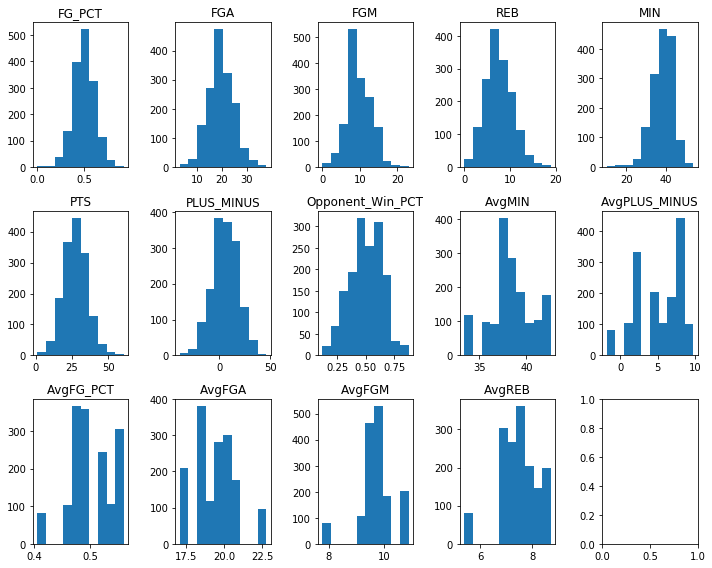

In [3]:
num1=['FG_PCT', 'FGA', 'FGM', 'REB', 'MIN', 'PTS','PLUS_MINUS','Opponent_Win_PCT',
      'AvgMIN','AvgPLUS_MINUS','AvgFG_PCT', 'AvgFGA', 'AvgFGM', 'AvgREB']
# To determine the distribution of our numerical data
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 8))
for c, ax in zip(num1, axes.ravel()):
    ax.hist(lbj[c].dropna(), bins=10)
    ax.set_title(c)
plt.tight_layout()
plt.show()

Well, it seems that our data are quite balanced, then no need to apply a log in this example. It might be useful though if we want to do the same on other players or on the full dataset.

__Built test and train sets__

In [4]:
# To check my columns
list(lbj)

['GAME_ID',
 'TEAM_ID',
 'TEAM_CITY',
 'PLAYER_NAME',
 'FG_PCT',
 'FGA',
 'FGM',
 'REB',
 'MIN',
 'PTS',
 'PLUS_MINUS',
 'GAME_DATE_EST',
 'TEAM_ID_home',
 'HOME_TEAM_CITY',
 'HOME_TEAM_WINS_x',
 'VISITOR_TEAM_CITY',
 'VISITOR_TEAM_WINS_x',
 'AvgMIN',
 'AvgPLUS_MINUS',
 'AvgFG_PCT',
 'AvgFGA',
 'AvgFGM',
 'AvgREB',
 'Opponent_Win_PCT',
 'TEAM_WIN',
 'SEASON_Ori',
 'weekday_Ori',
 'month_Ori',
 'START_POSITION_ori',
 'Home/Away_Ori',
 'Opponent_City_Ori',
 'START_POSITION_C',
 'START_POSITION_F',
 'START_POSITION_G',
 'START_POSITION_substitute',
 'SEASON_2003',
 'SEASON_2004',
 'SEASON_2005',
 'SEASON_2006',
 'SEASON_2007',
 'SEASON_2008',
 'SEASON_2009',
 'SEASON_2010',
 'SEASON_2011',
 'SEASON_2012',
 'SEASON_2013',
 'SEASON_2014',
 'SEASON_2015',
 'SEASON_2016',
 'SEASON_2017',
 'SEASON_2018',
 'SEASON_2019',
 'weekday_Friday',
 'weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'month_April',
 'month_December',


__ml_data__  *(Full Version)*<br>
Create the main set of features to be used, by removing the one I don't need or are overlapping and those that were used specifically for the EDA part. As a reminder I am working only with average from the season for the prediction, as I want to use only features that we ignore before the game start (e.g. we can't tell how much rebond the player will take during the game).

In [5]:
# Create the set of features to be used by removing the one I don't need or are overlapping
ml_data= lbj.drop(['GAME_ID', 'TEAM_ID', 'TEAM_CITY', 'PLAYER_NAME', 'FG_PCT', 'FGA', 'FGM', 'REB', 'MIN', 'PTS', 'PLUS_MINUS','GAME_DATE_EST',
                  'TEAM_ID_home','HOME_TEAM_CITY','VISITOR_TEAM_CITY', 'Opponent_City_Ori',
                   'SEASON_Ori', 'weekday_Ori', 'month_Ori', 'START_POSITION_ori', 'Home/Away_Ori',], axis=1)

In [6]:
# Full version
x= ml_data.values
y= lbj.PTS.values
print(x.shape)
print(y.shape)

(1563, 83)
(1563,)


In [7]:
# Split data for the test and train set
x_tr, x_te, y_tr, y_te = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)

__ml_lite__ *(Light Version)*<br> Here I create a second set, with less features. My choice is based on keeping only features that are the most releavant. For example I removed weekdays, because in my EDA I noticed that it did not bring a lot.

In [8]:
ml_lite= lbj[['AvgMIN', 'AvgPLUS_MINUS', 'AvgFG_PCT', 'AvgFGA', 'AvgFGM', 'AvgREB', 'Opponent_Win_PCT','START_POSITION_C', 'START_POSITION_F', 'START_POSITION_G',
             'START_POSITION_substitute', 'SEASON_2003', 'SEASON_2004', 'SEASON_2005', 'SEASON_2006', 'SEASON_2007', 'SEASON_2008', 'SEASON_2009', 'SEASON_2010', 'SEASON_2011',
             'SEASON_2012', 'SEASON_2013', 'SEASON_2014', 'SEASON_2015', 'SEASON_2016', 'SEASON_2017', 'SEASON_2018', 'SEASON_2019', 'month_April', 'month_December', 'month_February', 'month_January',
             'month_June', 'month_March', 'month_May', 'month_November', 'month_October', 'month_September', 'TEAM_WIN']]
# light version
x0= ml_lite.values
x0.shape

(1563, 39)

In [9]:
x_tr0, x_te0 = train_test_split(x0, train_size=0.8, test_size=0.2, random_state=0)

On top, I create a version to __standardize with the StandardScaler__ to avoid issue with the various features scale, especially when there is a lot of feature, to consider them equally important. This transformation will be applied for the KNN Regressor and with Huber Loss. I also tried tried a PCA transformation but I did not provide satisfying results, so I did not keep it.

In [10]:
from sklearn.preprocessing import StandardScaler
# Standardize data
scaler = StandardScaler()
# For the ml_data
x_tr1 = scaler.fit_transform(x_tr)
x_te1 = scaler.transform(x_te)
# For the ml_lite
x_tr00 = scaler.fit_transform(x_tr0)
x_te00 = scaler.transform(x_te0)

In [11]:
# Check data shape
print(x_tr.shape)
print(y_tr.shape)
print(x_te.shape)
print(y_te.shape)
print(x_tr1.shape)
print(x_te1.shape)
print(x_tr00.shape)
print(x_te00.shape)

(1250, 83)
(1250,)
(313, 83)
(313,)
(1250, 83)
(313, 83)
(1250, 39)
(313, 39)


### Models

To run my __supervised learning model__, I use differents method such as:
 - Multiple linear regression (no scaling)
     - It is a good first approach to predict continuous values.
 - Huber loss (scaling, provided a better results after having tried both)
     - As we previously noticed, our dataset has a few outliers (really a few...), Huber Loss is robust in dealing with those.
 - Knn regressor (require scaling), with and without Hyperparamters tuning.
     - To calculate the distance and capture the idea of similarity cases amongst my data.
 - Random Forest regressor (no scaling), with and without Hyperparamters tuning.
   - It seems that this ensemble decision tree model using bagging approach works pretty well with non numeric data, and I have quite some in dataset.
 
I initially tried with a Ridge regression model, but results were not better, then I decided to remove.<br>
Let's discover results below.

__Set the baseline__

As a metrics, I'll use the mean absolute error (MAE) to measures the absolute values of the residuals. I hesitated to used the accuracy of my models, but I find it less talkative in this case. Indeed as we talking about points, it is easier to interpret.

In [12]:
#MAE as baseline 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

___Multiple Linear Regression___

First I try to run my model with the linear regression.<br>
__Light Version__

In [13]:
from sklearn.linear_model import LinearRegression
# linear regression light Version
lr0 = LinearRegression()
lr0.fit(x_tr0, y_tr)
y_pred_lr0 = lr0.predict(x_te0)

mae_lr0 = MAE(y_te, y_pred_lr0)
print('MAE linear regression Light Version: {:.3f}'.format(mae_lr0))

MAE linear regression Light Version: 5.938


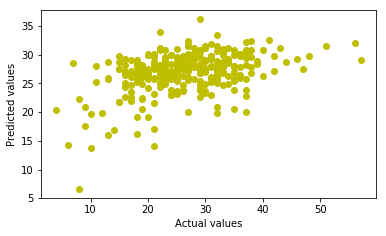

In [14]:
# Plot to compare predicted vs Actual 
plt.plot(y_te, y_pred_lr0, 'yo')
plt.axis('scaled')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

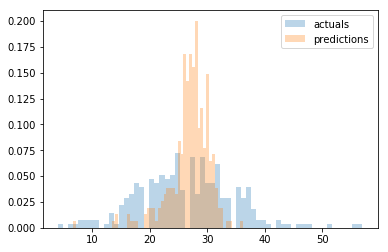

In [15]:
# Plot prediction
plt.hist(y_te, density=True, alpha=0.3, label='actuals', bins=60)
plt.hist(y_pred_lr0, density=True, alpha=0.3, label='predictions', bins=60)
plt.legend()
plt.show()

As we can see in this chart and all the following similar ones below, predicted and actuals are not too far from each others. Actual values contains a few extremly high (and low) values, that are difficult to predict and can even be considered as outliers.

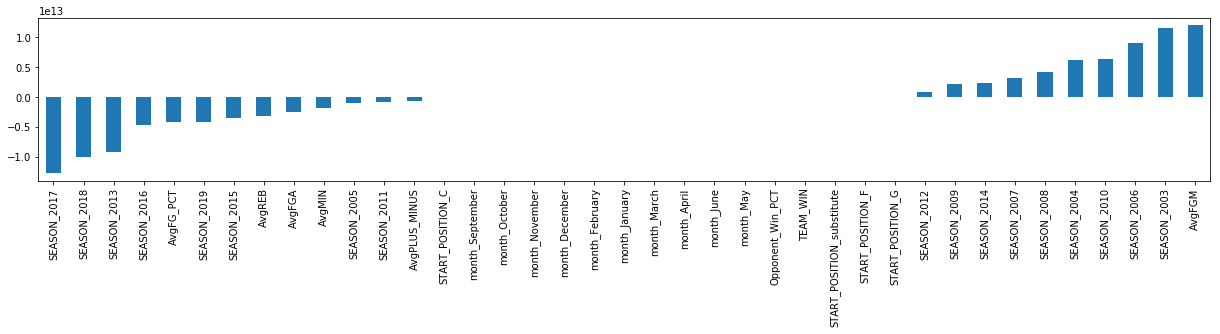

In [16]:
# To determine feature importance with the coefficient method
coef0 = pd.Series(lr0.coef_, index = ml_lite.columns)
imp_coef0 = coef0.sort_values()
imp_coef0.plot(kind = "bar", figsize=(21,3));

This chart displays the coef / feature importance. Quite interestingly, we notice that some features seem to have no impact at all. <br>
In general, with those charts (this one and others below) I decided to not remove any of them, because if we detect that they don't have an impact on this selected player, it might be not the case with other players.

In [17]:
# linear regression full version
lr = LinearRegression()
lr.fit(x_tr, y_tr)
y_pred_lr = lr.predict(x_te)

mae_lr = MAE(y_te, y_pred_lr)
print('MAE linear regression Full Version: {:.3f}'.format(mae_lr))

MAE linear regression Full Version: 5.966


This results is actually quite good and even better with the light version as the Prediction is below 6 points. It's not really clear to me why some feature are more important for this player.


___Huber Loss___

For the second model, I try to run it with the Huber Loss regressor, starting with the __Light Version__

In [18]:
from sklearn.linear_model import HuberRegressor
# Huber Loss light version
huber1 = HuberRegressor(epsilon=1.4, max_iter=7)
huber1.fit(x_tr00, y_tr)
y_pred_huber00 = huber1.predict(x_te00)

mae_huber00 = MAE(y_te, y_pred_huber00)
print('MAE Huber Light Version: {:.3f}'.format(mae_huber00))

MAE Huber Light Version: 5.857


__Full Version__

In [19]:
# Huber Loss full version
huber = HuberRegressor(epsilon=1.2, max_iter=12)
huber.fit(x_tr1, y_tr)
y_pred_huber1 = huber.predict(x_te1)

mae_huber1 = MAE(y_te, y_pred_huber1)
print('MAE Huber Full Version: {:.3f}'.format(mae_huber1))

MAE Huber Full Version: 5.829


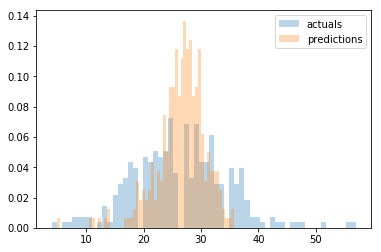

In [20]:
# Plot prediction
plt.hist(y_te, density=True, alpha=0.3, label='actuals', bins=60)
plt.hist(y_pred_huber1, density=True, alpha=0.3, label='predictions', bins=60)
plt.legend()
plt.show()

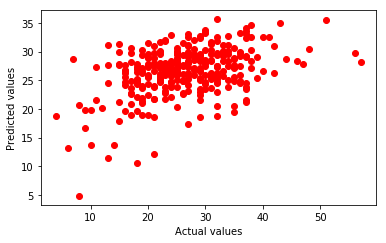

In [21]:
# Plot to compare predicted vs Actual 
plt.plot(y_te, y_pred_huber1, 'ro')
plt.axis('scaled')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

It seems that Huber loss regression is performing slightly better to predict the low value than the linear regression. Maybe link to its ability to deal with outliers.

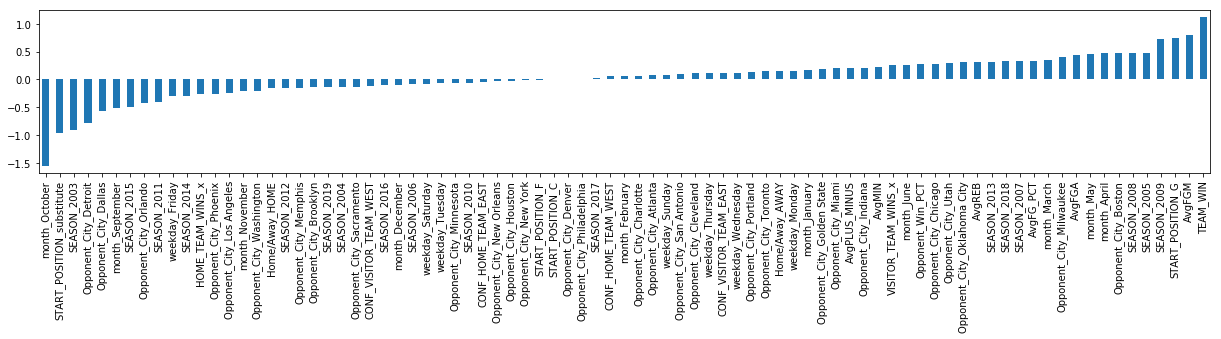

In [22]:
# To determine feature importance with the coefficient method
coef = pd.Series(huber.coef_, index = ml_data.columns)
imp_coef = coef.sort_values()
imp_coef.plot(kind = "bar", figsize=(21,3));

Compared to the multiple linear regression, our results are slightly better as we could close the gap a bit more. Interestingly enough, I got almost the result amongst my two datasets (full and lite).<br> On this occasion, I have just played around with the epsilon and the iter to get a good results. As we can see, except a few, every features have "importance".

___KNN Regressor___

KNN regressor and Random Forest Regressor (next one) seems to works pretty well with non numeric data. <br>
First I'll work with the simple version before trying to tune the hyperparameters with gridsearch cross validation.

Original __light version__.<br>
With default parameters.

In [23]:
from sklearn.neighbors import KNeighborsRegressor
# KNN regressor light version
neigh = KNeighborsRegressor()
neigh.fit(x_tr00, y_tr)
y_pred_KnnReg00 = neigh.predict(x_te00)

mae_KnnReg00 = MAE(y_te, y_pred_KnnReg00)
print('MAE KnnRegressor Light Version: {:.3f}'.format(mae_KnnReg00))

MAE KnnRegressor Light Version: 6.329


Then let's try to finetune the parameters using Kfold to work on the train data before doing the final test on test set.

In [24]:
# Create the pipe
pipe = Pipeline([('kn',KNeighborsRegressor(n_neighbors=28, weights='uniform', leaf_size=30 ,p=2))])
# parameters Grid
grid = {'kn__n_neighbors':[20,23,24,25,26,27,30],
        'kn__weights': ['distance','uniform'],
        'kn__leaf_size':[5,7,9,10,12,14,15,16,17,20],
        'kn__p':[1, 2, 3]}                                                 
# Kfold
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
# Add Cross validation
grid_cv_kn = GridSearchCV(pipe, grid, cv=kfold, return_train_score=True, n_jobs=2, scoring='neg_mean_absolute_error')
grid_cv_kn.fit(x_tr00, y_tr)

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=28, p=2,
          weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'kn__n_neighbors': [20, 23, 24, 25, 26, 27, 30], 'kn__weights': ['distance', 'uniform'], 'kn__leaf_size': [5, 7, 9, 10, 12, 14, 15, 16, 17, 20], 'kn__p': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

Below I tried two way to get the best estimators, whithout creating a DF.

In [25]:
grid_cv_kn.best_estimator_

Pipeline(memory=None,
     steps=[('kn', KNeighborsRegressor(algorithm='auto', leaf_size=14, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=23, p=1,
          weights='uniform'))])

In [26]:
# Display the best params
grid_cv_kn.best_params_

{'kn__leaf_size': 14,
 'kn__n_neighbors': 23,
 'kn__p': 1,
 'kn__weights': 'uniform'}

I will eventually apply the best parameters chosen by the models

In [27]:
neigh = KNeighborsRegressor(n_neighbors=23, weights='uniform', leaf_size=14 ,p=1)
neigh.fit(x_tr00, y_tr)
y_pred_KnnReg00 = neigh.predict(x_te00)

mae_KnnReg00 = MAE(y_te, y_pred_KnnReg00)
print('MAE KnnRegressor Light Version after HP finetune: {:.3f}'.format(mae_KnnReg00))

MAE KnnRegressor Light Version after HP finetune: 6.123


On this occasion, HP tuning helped quite significantly. But the result is not amazing.

Below I work with the __Full Version__, This time as a starting point I just added a parameters randomly.

In [28]:
# KNN regressor full version
neigh = KNeighborsRegressor(n_neighbors=28)
neigh.fit(x_tr1, y_tr)
y_pred_KnnReg1 = neigh.predict(x_te1)

mae_KnnReg1 = MAE(y_te, y_pred_KnnReg1)
print('MAE KnnRegressor Full Version: {:.3f}'.format(mae_KnnReg1))

MAE KnnRegressor Full Version: 5.951


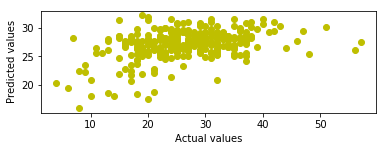

In [29]:
# Plot to compare predicted vs Actual 
plt.plot(y_te, y_pred_KnnReg1, 'yo')
plt.axis('scaled')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

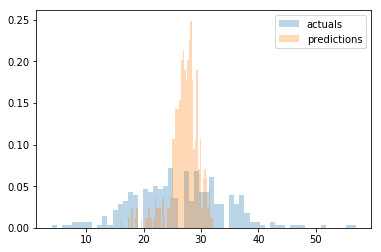

In [30]:
# Plot prediction
plt.hist(y_te, density=True, alpha=0.3, label='actuals', bins=60)
plt.hist(y_pred_KnnReg1, density=True, alpha=0.3, label='predictions', bins=60)
plt.legend()
plt.show()

As diplayed above, KNN being seems to not display extrem values (high or low).

As already done above, the pipe below to __Fine Tune my hyperparameters__ using KFold splitting in 2 my trainset.

In [31]:
# Create the pipe
pipe = Pipeline([('kn',KNeighborsRegressor(n_neighbors=28, weights='uniform', leaf_size=30 ,p=2))])
# parameters Grid
grid = {'kn__n_neighbors':[15,20,23,24,25,27,30],
        'kn__weights': ['distance','uniform'],
        'kn__leaf_size':[10,15,18,20,25,30],
        'kn__p':[1, 2, 3]}                                                 
# Kfold
kfold = KFold(n_splits=2, shuffle=True, random_state=0)
# Add Cross validation
grid_cv_kn_fu = GridSearchCV(pipe, grid, cv=kfold, return_train_score=True, n_jobs=2, scoring='neg_mean_absolute_error' )
grid_cv_kn_fu.fit(x_tr1, y_tr)

GridSearchCV(cv=KFold(n_splits=2, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=28, p=2,
          weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'kn__n_neighbors': [15, 20, 23, 24, 25, 27, 30], 'kn__weights': ['distance', 'uniform'], 'kn__leaf_size': [10, 15, 18, 20, 25, 30], 'kn__p': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

Also here, I tried other way to way to get the best parameters.

In [32]:
cv_resultskn = pd.DataFrame(grid_cv_kn_fu.cv_results_)
cols = ['mean_test_score', 'mean_train_score', 'param_kn__n_neighbors', 'param_kn__weights', 'param_kn__leaf_size','param_kn__p' ]
cv_resultskn[cols].sort_values('mean_test_score', ascending=False).head(1)

,mean_test_score,mean_train_score,param_kn__n_neighbors,param_kn__weights,param_kn__leaf_size,param_kn__p
144,-6.217208,-0.0184,24,distance,20,1


In [33]:
# Display the best params
grid_cv_kn_fu.best_params_

{'kn__leaf_size': 20,
 'kn__n_neighbors': 24,
 'kn__p': 1,
 'kn__weights': 'distance'}

Then I used my best parameters to run my previous code.

In [34]:
neigh = KNeighborsRegressor(n_neighbors=24, weights='distance', leaf_size=20 ,p=1)
neigh.fit(x_tr1, y_tr)
y_pred_KnnReg1_hp = neigh.predict(x_te1)

mae_KnnReg1_hp = MAE(y_te, y_pred_KnnReg1_hp)
print('MAE KnnRegressor Full Version after HP finetune: {:.3f}'.format(mae_KnnReg1_hp))

MAE KnnRegressor Full Version after HP finetune: 6.095


Here I notice that after hyperparameters tuning our results are not always better and don't vary much. This may be because the model have been trained and validated on the train set (after Kfold). The model have not seen the test set before, then the hyperparameters may not be the best for the test set. Maybe adding some more choice for our hyperparameters could have enhanced our results, or my amount of rows is not big enough. Another reason could be that __my model overfit on the train set__, and therefore is not able to perform that well on the test set.

___Random Forest Regressor___

First trial with random Forest Regressor with __Light Version__, the results is already good, below find the version with tuned hyperparameters.

In [35]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, n_estimators=10, random_state=0)
regr.fit(x_tr0, y_tr)
y_pred_RandFor0 = regr.predict(x_te0)

mae_RandFor0 = MAE(y_te, y_pred_RandFor0)
print('MAE Random Forest Regressor Light Version: {:.3f}'.format(mae_RandFor0))

MAE Random Forest Regressor Light Version: 5.949


Hyperparameters tuning.

In [36]:
# Create the pipe
pipe = Pipeline([('rf',RandomForestRegressor(max_depth=5, n_estimators=10, random_state=0))])
# parameters Grid
grid = {'rf__n_estimators':[20,30,35,40,45,50],
        'rf__max_depth':[2, 3, 4, 5, 6, 10],
        'rf__criterion':['mse','mae']}                                                 
# Kfold
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
# Add Cross validation
grid_cv = GridSearchCV(pipe, grid, cv=kfold, return_train_score=True, n_jobs=2, scoring='neg_mean_absolute_error')
grid_cv.fit(x_tr0, y_tr)

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'rf__n_estimators': [20, 30, 35, 40, 45, 50], 'rf__max_depth': [2, 3, 4, 5, 6, 10], 'rf__criterion': ['mse', 'mae']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [37]:
# Display the best params
grid_cv.best_params_

{'rf__criterion': 'mae', 'rf__max_depth': 5, 'rf__n_estimators': 40}

Then apply our best parameters.

In [38]:
regr = RandomForestRegressor(max_depth=5, criterion='mae', n_estimators=40, random_state=0)
regr.fit(x_tr0, y_tr)
y_pred_RandFor0 = regr.predict(x_te0)

mae_RandFor0 = MAE(y_te, y_pred_RandFor0)
print('MAE Random Forest Regressor Light Version after HP finetune: {:.3f}'.format(mae_RandFor0))

MAE Random Forest Regressor Light Version after HP finetune: 5.860


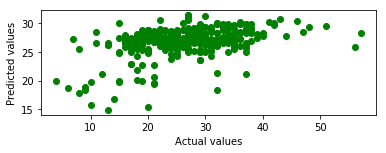

In [39]:
# Plot to compare predicted vs Actual 
plt.plot(y_te, y_pred_RandFor0, 'go')
plt.axis('scaled')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

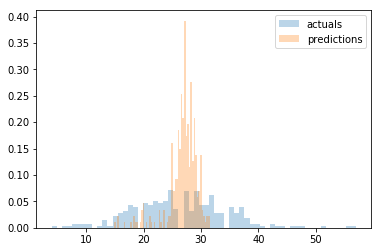

In [40]:
# Plot prediction
plt.hist(y_te, density=True, alpha=0.3, label='actuals', bins=60)
plt.hist(y_pred_RandFor0, density=True, alpha=0.3, label='predictions', bins=60)
plt.legend()
plt.show()

Here the visual is a bit different than others. It seems more packed on top and a with some unusual with space, the range of prediction is also quite limited, maybe slightly underfitting.  

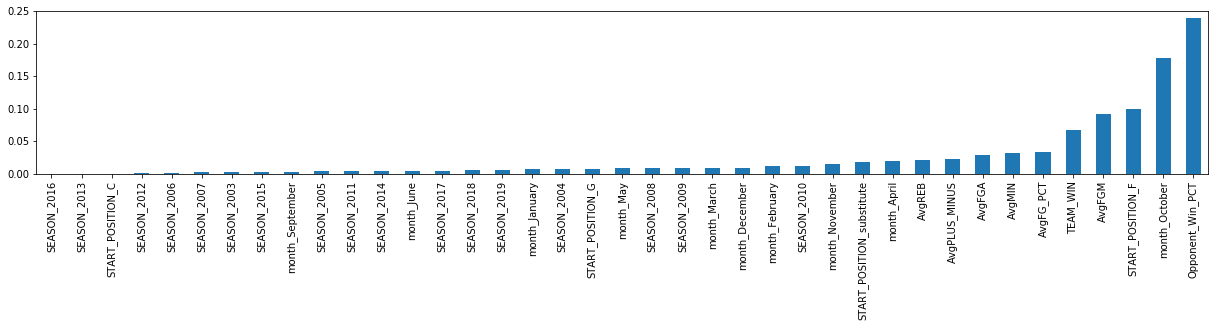

In [41]:
# To determine feature importance with the coefficient method
feat_imp = pd.Series(regr.feature_importances_, index = ml_lite.columns)
feat_imp = feat_imp.sort_values()
feat_imp.plot(kind = "bar", figsize=(21,3));

The features that have an importance makes sense.

__Full Version__

In [42]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(x_tr, y_tr)
y_pred_RandFor = regr.predict(x_te)

mae_RandFor = MAE(y_te, y_pred_RandFor)
print('MAE Random Forest Regressor Full version: {:.3f}'.format(mae_RandFor))

C:\Users\nicolas\Anaconda3\envs\exts-ml\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MAE Random Forest Regressor Full version: 5.939


In [43]:
# Create the pipe
pipe = Pipeline([('rf',RandomForestRegressor(max_depth=5, n_estimators=10, random_state=0))])
# parameters Grid
grid = {'rf__n_estimators':[135,138,140,142,145],
        'rf__max_depth':[9,10,11,12],
        'rf__criterion':['mse','mae']}                                                 
# Kfold
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
# Add Cross validation
grid_cv_fu = GridSearchCV(pipe, grid, cv=kfold, return_train_score=True, n_jobs=2, scoring='neg_mean_absolute_error')
grid_cv_fu.fit(x_tr, y_tr)

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'rf__n_estimators': [135, 138, 140, 142, 145], 'rf__max_depth': [9, 10, 11, 12], 'rf__criterion': ['mse', 'mae']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [44]:
grid_cv_fu.best_params_

{'rf__criterion': 'mae', 'rf__max_depth': 10, 'rf__n_estimators': 138}

In [45]:
regr = RandomForestRegressor(max_depth=10, n_estimators=138, criterion='mae', random_state=0)
regr.fit(x_tr, y_tr)
y_pred_RandFor = regr.predict(x_te)

mae_RandFor = MAE(y_te, y_pred_RandFor)
print('MAE Random Forest Regressor Full version After Tune: {:.3f}'.format(mae_RandFor))

MAE Random Forest Regressor Full version After Tune: 5.949


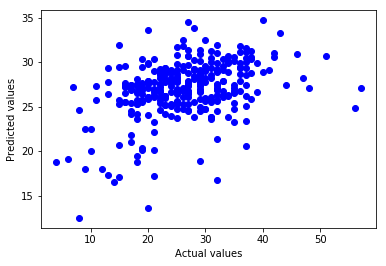

In [46]:
# Plot to compare predicted vs Actual 
plt.plot(y_te, y_pred_RandFor, 'bo')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

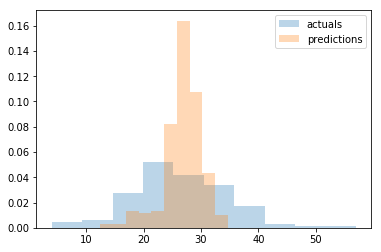

In [47]:
plt.hist(y_te, density=True, alpha=0.3, label='actuals')
plt.hist(y_pred_RandFor, density=True, alpha=0.3, label='predictions')
plt.legend()
plt.show()

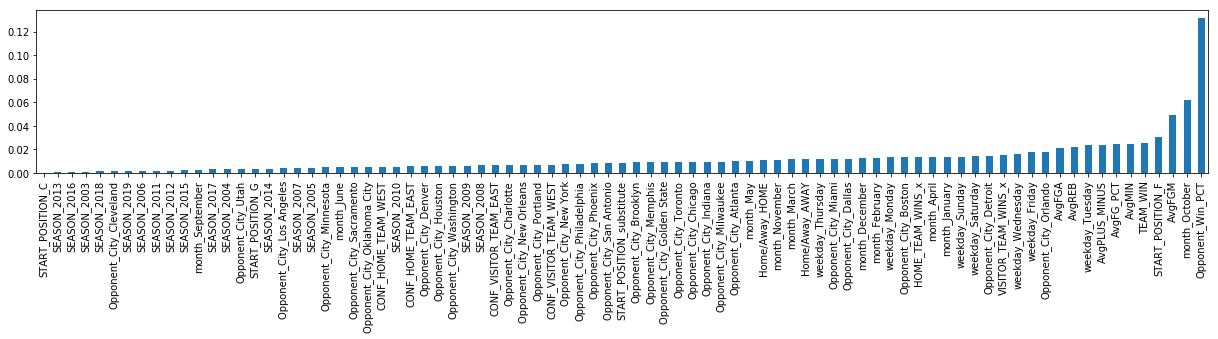

In [48]:
# To determine feature importance with the coefficient method
feat_impfu = pd.Series(regr.feature_importances_, index = ml_data.columns)
feat_impfu = feat_impfu.sort_values()
feat_impfu.plot(kind = "bar", figsize=(21,3));

None of the feature, except the first have no impact.
My two Random Forest Regressor operates quite well with this player, both version. 

__Test with Ridge__

In [51]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.5)
ridge.fit(x_tr1, y_tr)
y_values_ridge1 = ridge.predict(x_te1)

mae_rid1 = MAE(y_te, y_values_ridge1)
print('MAE Ridge Full Version: {:.3f}'.format(mae_rid1))

MAE Ridge Full Version: 5.965


In [59]:
# Create the pipe
pipe = Pipeline([('ri',Ridge(alpha=1.5, random_state=0))])
# parameters Grid
grid = {'ri__alpha':np.logspace(-10, 10, num=100)}                                                 
# Kfold
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
# Add Cross validation
grid_cv_ri = GridSearchCV(pipe, grid, cv=kfold, return_train_score=True, n_jobs=2, scoring='neg_mean_absolute_error')
grid_cv_ri.fit(x_tr00, y_tr)

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ri', Ridge(alpha=1.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=0, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'ri__alpha': array([1.00000e-10, 1.59228e-10, ..., 6.28029e+09, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [60]:
grid_cv_ri.best_params_

{'ri__alpha': 12.915496650148826}

In [61]:
cv_resultsri = pd.DataFrame(grid_cv_ri.cv_results_)
cols = ['mean_test_score', 'mean_train_score','param_ri__alpha' ]
cv_resultsri[cols].sort_values('mean_test_score', ascending=False).head(1)

,mean_test_score,mean_train_score,param_ri__alpha
55,-6.08297,-5.880668,12.9155


In [63]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=12.915496650148826)
ridge.fit(x_tr00, y_tr)
y_values_ridge1 = ridge.predict(x_te00)

mae_rid1 = MAE(y_te, y_values_ridge1)
print('MAE Ridge Full Version: {:.3f}'.format(mae_rid1))

MAE Ridge Full Version: 5.930


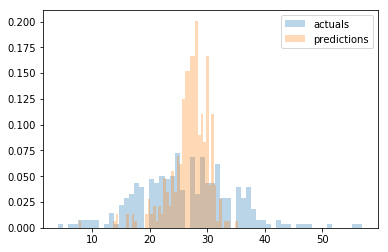

In [64]:
# Plot prediction
plt.hist(y_te, density=True, alpha=0.3, label='actuals', bins=60)
plt.hist(y_values_ridge1, density=True, alpha=0.3, label='predictions', bins=60)
plt.legend()
plt.show()

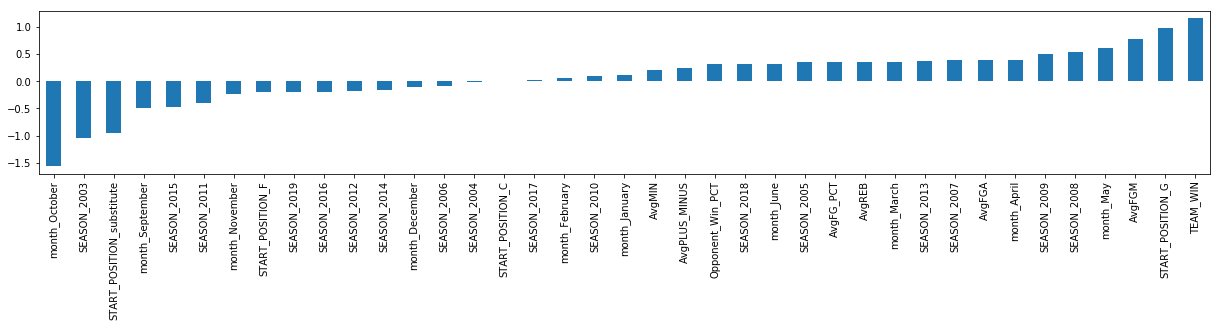

In [66]:
feat = pd.Series(ridge.coef_, index = ml_lite.columns)
feat = feat.sort_values()
feat.plot(kind = "bar", figsize=(21,3));

### Final Comparison

In [49]:
# Final comparison
# Baseline
mae_baseline = MAE(y_te,np.mean(y_te))
print(mae_baseline)

6.462840286212986


On the bar plot below, I decided to display only the most performing of each model.

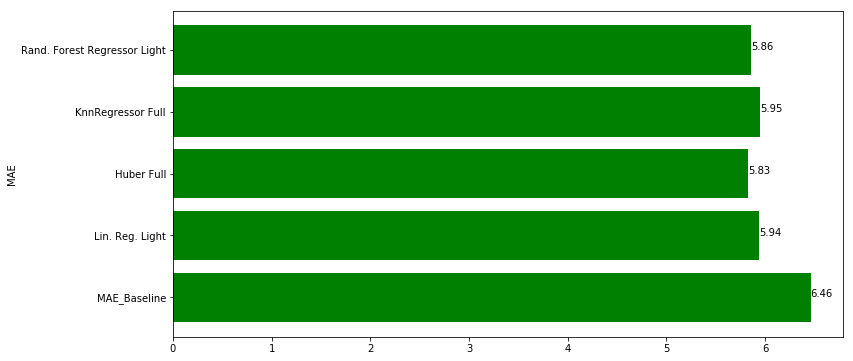

In [50]:
# Bar plot
mae_values = [mae_baseline, mae_lr0, mae_huber1, mae_KnnReg1, mae_RandFor0 ]
titles = ['MAE_Baseline', 'Lin. Reg. Light','Huber Full', 'KnnRegressor Full', 'Rand. Forest Regressor Light']

xcor = np.arange(len(mae_values))
plt.figure(figsize=(12,6))
plt.barh(xcor, mae_values,color='green')
plt.yticks(xcor, titles)

for index, value in enumerate(mae_values):
    plt.text(value, index, ("%.2f" % value))

plt.ylabel('MAE')
plt.show()

Except my linear regression and my RandomForest, the two others models performed slightly (very slightly...) better with the full dataset. It means that my models benefit somehow of my feature Engeenering. 

As we can see, my best model is the Huber Loss. which has the result of 5.83 which represent the absolute values of the residuals in points. It perform 10% better than its baseline. I might re-use my model later on to predict the next season as the current one is on hold. Let's have a look on my second player if results are similar.

As already mentioned, LeBron James is quite regular over the seasons. It is not the kind of player with big variation, then tough to predict.

### Conclusion

__Capstone project__

It was for me really interesting to deepdive into a subject that I like. I basically try to predict the unpredictable... And actually I am pretty glad of the result, even if is far from perfect.

Most likely that my model could be even more robust with others models, with extra feature engineering, but in this topic there is a strong component link to the human itself, that will remain unpredictable. The more I was doing, the more I noticed I could go further. But I had to refrain myself not to go in some direction even if it would have been interesting. This comment is valid especially in the EDA part where I was tempt (sometimes just for my knowledge) to cross information and see potential correlation, or just to discover new things. In this ML part, I also think that it is quite easy to try to change and adjust the feature 100 times and testing all available models... 


__Overall courses__

Over the 4 modules, I had the opportunity to learn quite a lot of new topic and also to refresh some very old concept that I had vaguely studied one or two decades ago. I personnaly see usage of the 2 first modules in my daily work, as in my professional life I have to handle quite a lot of data on various spreadsheets. The modules about machine learning were more out of curiosity, but I am convinced that having built knowledge in this field is key for tomorrow's world.